In [4]:
import numpy as np
import magpylib as magpy
import pandas as pd
from magpylib.magnet import Cuboid, Cylinder, CylinderSegment
from maggeometry import n_rings, halbach_cylinder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from maghelper import get_field_on_axes, get_nonuniformity, make_flux_stream, centered_sweep_range, get_grid_mag_and_nonuniformity, make_xy_grid, make_xz_grid, get_cuboid_nonuniformity_coverage, plot_uniform_region_side_view, make_xyz_grid
import matplotlib.cm as cm

## For best candidate geometry

In [35]:
def plot_plane_field_strength(magnets, x_grid_bounds, y_grid_bounds, z_elev, plot_nonuniformity = True):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], 101)
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], 101)
    grid = np.array([[(x,y,z_elev) for x in ts_x] for y in ts_y])

    #get magnetic field
    mT_to_G = 10
    B = magnets.getB(grid)
    G = B * mT_to_G

    #matplotlib contour plot
    # ax = plt.figure().add_subplot(projection='3d')
    # surf = ax.plot_surface(grid[:,:,0], grid[:,:,1], B[:,:,2], linewidth=0)
    
#     Gz = G[:,:,2]
    Gmag = np.linalg.norm(G, axis=2)
    
    fig_base = make_subplots(rows=2, cols=1,
                             specs=[[{'type': 'surface'}], [{'type': 'surface'}]],
                             subplot_titles = [f'Field strength in plane z={z_elev}',
                                               f'Field nonuniformity in plane z={z_elev}'
                                              ],
                             shared_yaxes=False
                            )
    
    fig_base.add_trace(
        go.Surface(x=grid[:,:,0], y=grid[:,:,1], z=Gmag),
        row=1, col=1
    )
    
    if plot_nonuniformity:
        mid_idx = int(len(ts_x)/2)
        mid_idy = int(len(ts_y)/2)
        G_center = Gmag[mid_idx][mid_idy]
        G_non = np.abs((Gmag - G_center)/G_center)
#         G_center = Gz[mid_idx][mid_idy]
#         G_non = np.abs((Gz - G_center)/G_center)
        
        fig_base.add_trace(
            go.Surface(x=grid[:,:,0], y=grid[:,:,1], z=G_non),
            row=2, col=1
        )
    plot_height = 2000
    fig_base.update_layout(
        height=plot_height,
        width=plot_height/2,
    )
    fig_base.update_traces(showscale=False)
    fig_base.show()

def get_field_on_axes(magnets, sensor_bounds, is_logscale=True):
    x_sensor_bounds, y_sensor_bounds, z_sensor_bounds = sensor_bounds
    # define sensor axis in 3d space
    sens_res = 5000
    x_senpos = np.linspace((x_sensor_bounds[0], 0, 0), (x_sensor_bounds[1], 0, 0), sens_res)
    # initialize sensor
    x_sen = magpy.Sensor(position=x_senpos)

    y_senpos = np.linspace((0, y_sensor_bounds[0], 0 ), (0, y_sensor_bounds[1], 0), sens_res)
    y_sen = magpy.Sensor(position=y_senpos)
    
    z_senpos = np.linspace((0, 0, z_sensor_bounds[0]), (0, 0, z_sensor_bounds[1]), sens_res)
    z_sen = magpy.Sensor(position=z_senpos)
    
    # read from transverse and axial sensors
    # convert from returned mT readings to Gauss
    mT_to_G = 10
    x_Bz = x_sen.getB(magnets).T[2]
    y_Bz = y_sen.getB(magnets).T[2]
    z_Bz = z_sen.getB(magnets).T[2]
    xb, yb, zb = [x_sen.getB(magnets), y_sen.getB(magnets), z_sen.getB(magnets)]
    print(xb)
    xbn = np.linalg.norm(xb, axis=1) * mT_to_G
    ybn = np.linalg.norm(yb, axis=1) * mT_to_G
    zbn = np.linalg.norm(zb, axis=1) * mT_to_G

    # convert from returned mT readings to Gauss
    mT_to_G = 10
    x_Gz = x_Bz * mT_to_G
    y_Gz = y_Bz * mT_to_G
    z_Gz = z_Bz * mT_to_G
    
    # set plotting configurations
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    # plt.rcParams.update({'font.size': 14})
    
    fig_width = 15
    fig, axs = plt.subplots(2, 3, figsize=(fig_width, 2/3*fig_width))
    axs = axs.flat
    
    # 1. plot the B_z component on each of the three sensor axes
    axs[0].set_ylabel("Gauss")
    axs[0].set_xlabel("mm")
    axs[0].plot(x_senpos[:, 0], xbn)
    axs[0].set_title("B-field variation on x-axis")
    axs[0].grid(color='.9', which='major', axis='both', linestyle='-')

    # axs[1].set_ylabel("Gauss")
    axs[1].set_xlabel("mm")
    axs[1].plot(y_senpos[:, 1], ybn)
    axs[1].set_title("B-field variation on y-axis")
    axs[1].grid(color='.9', which='major', axis='both', linestyle='-')

    # axs[2].set_ylabel("Gauss")
    axs[2].set_xlabel("mm")
    axs[2].plot(z_senpos[:, 2], zbn)
    axs[2].set_title("B-field variation on z-axis")
    axs[2].grid(color='.9', which='major', axis='both', linestyle='-')
    
    # 2. get nonuniformity along each of the 3 axes
    x_Gnon, x_min_nonuniformity, x_max_nonuniformity, x_av_nonuniformity = get_nonuniformity(xbn, "x", sens_res)
    y_Gnon, y_min_nonuniformity, y_max_nonuniformity, y_av_nonuniformity = get_nonuniformity(ybn, "y", sens_res)
    z_Gnon, z_min_nonuniformity, z_max_nonuniformity, z_av_nonuniformity = get_nonuniformity(zbn, "z", sens_res)
    
    # 3. set nonuniformity plots to logscale
    if (is_logscale):
        axs[3].set_yscale("log")
        axs[4].set_yscale("log")
        axs[5].set_yscale("log")
    
    
    # 4. plot nonuniformity
    axs[3].plot(x_senpos[:, 0], x_Gnon)
    axs[3].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[3].set_ylim(x_min_nonuniformity - 1e-7, x_max_nonuniformity + 1e-7)
    axs[3].set_title('Nonuniformity profile on x-axis')
    axs[3].set_xlabel("mm")
    
    axs[4].plot(y_senpos[:, 1], y_Gnon)
    axs[4].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[4].set_ylim(y_min_nonuniformity - 1e-7, y_max_nonuniformity + 1e-7)
    axs[4].set_title('Nonuniformity profile on y-axis')
    axs[4].set_xlabel("mm")
    
    axs[5].plot(z_senpos[:, 2], z_Gnon)
    axs[5].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[5].set_ylim(z_min_nonuniformity - 1e-7, z_max_nonuniformity + 1e-7)
    axs[5].set_title('Nonuniformity profile on z-axis')
    axs[5].set_xlabel("mm")

    plt.tight_layout()
    plt.savefig('figs/halbachbestcnonunprofiles.png', dpi=500)
    
    # temp_fig = go.Figure(layout=go.Layout(height=600, width=600)) 
    temp_fig = go.Figure() 
    magpy.show(magnets, canvas=temp_fig, style_magnetization_show=True, backend='plotly')
    # magpy.show(magnets, x_sen, y_sen, z_sen, canvas=temp_fig, style_magnetization_show=True, backend='plotly')
    temp_fig.update_layout(height=1000, width=1000)
    temp_fig.show()
    sq = 10
    plot_plane_field_strength(magnets, [-sq, sq], [-sq, sq], 0)

def get_grid_mag_and_nonuniformity(magnets, grid, grid_res, use_z=False):
    mT_to_G = 10
    B = magnets.getB(grid)
    G = B * mT_to_G
    # find magnitude of the b-field at all points over grid
    Gmag = 0
    if use_z:
        Gmag = G[:,:,2]
    else:
        Gmag = np.linalg.norm(G, axis=2)
#     Gmag = np.sqrt(G[:,:,0]**2 + G[:,:,1]**2 + G[:,:,2]**2)
#     Gmag = G[:,:,2]
    # find magnitude of b-field at center of grid
    mid_id = int(grid_res/2)
    Gcenter = Gmag[mid_id][mid_id]
    # calculate nonuniformity with respect to center b-field
    Gnon = np.abs((Gmag - Gcenter)/Gcenter)
    max_nonuniformity = np.max(Gnon)
    av_nonuniformity = np.sum(Gnon) / grid_res**2
    return Gmag, Gnon, Gcenter, av_nonuniformity, max_nonuniformity

def make_flux_stream(magnets, x_grid_bounds, z_grid_bounds, mag_draw_bounds):
#     ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], 101)
#     ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], 101)
#     grid = np.array([[(x,0,z) for x in ts_x] for z in ts_z])
    grid_res = 101
    grid, X, Z = make_xz_grid(x_grid_bounds, z_grid_bounds, grid_res)
    
    #get magnetic field
    B = magnets.getB(grid)
    
    #plot flux stream
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    ax1.set_aspect('equal')
    ax1.streamplot(grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2], density=2,
        color=np.log(np.linalg.norm(B, axis=2)), linewidth=1, cmap='autumn', broken_streamlines=False)
    #plot coil cross section
    for poly in mag_draw_bounds:
        ax1.plot(poly[0], poly[1],'k--')
    ax1.set_ylabel("mm")
    ax1.set_xlabel("mm")
    plt.savefig('figs/halbachbestcstreamplot.png', dpi=500)

In [177]:
def get_cuboid_nonuniformity_coverage(magnets, x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res=201, threshold=1e-7):
    grid, X, Y, Z = make_xyz_grid(x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res)
    B = magpy.getB(magnets, grid)
    Bmag = np.linalg.norm(B, axis=3)
    c = int(grid_res/2)
    nonun = np.abs((Bmag - Bmag[c,c,c]) / Bmag[c,c,c])
    
    # Count volume of enclosed uniform area
    p_uni = np.count_nonzero(nonun < threshold)
    # Volume of box defined by bounds
    p_cuboid = nonun.size
    print(p_cuboid)
    p_ratio = p_uni / p_cuboid
    
    # Get lengths of bounding cuboid
    region_x = np.abs(x_grid_bounds[0] - x_grid_bounds[1])
    region_y = np.abs(y_grid_bounds[0] - y_grid_bounds[1])
    region_z = np.abs(z_grid_bounds[0] - z_grid_bounds[1])
    
    v_cuboid = region_x * region_y * region_z
    v_uni = p_ratio * v_cuboid
    # Print results
    print(f"Proportion of uniform region ({threshold}) in central {region_x} * {region_y} * {region_z} = {v_cuboid} mm^3: {round(p_ratio * 100, 3)}%")
    print(f"Volume of uniform region ({threshold}): {round(v_uni, 3)} mm^3 = {round(v_uni/1000, 3)} cm^3")
    return v_uni

In [178]:
d = 50
h = 50
b = 50
x = results2_x[0]
obj_ring_config=[[*ringset_1_config, *x[2:6]], [*ringset_2_config, *x[6:10]]]
magnets = n_rings(obj_ring_config)
v_uni = get_cuboid_nonuniformity_coverage(magnets, [-d, d], [-b, b], [-h, h], 101)

1030301
Proportion of uniform region (1e-07) in central 100 * 100 * 100 = 1000000 mm^3: 1.192%
Volume of uniform region (1e-07): 11917.876 mm^3 = 11.918 cm^3


In [130]:
v_uni / (340*340*620) * 100

0.016628357554419503

In [179]:
# ECR fill ratio bounded to ringsets in percent
v_uni / ((2*x[6] + 2*x[7])**2 * (2*x[9]+x[8])) * 100

0.03047538331630776

In [180]:
(2*x[6] + 2*x[7])**2 * (2*x[9]+x[8])

39106567.75898908

In [131]:
print(x[2:6], x[6:10])

[ 13.9338163   16.0980807    2.48949037 190.7487021 ] [146.02657609   9.96220472   7.7809518  197.00630916]


['results/halbach/pippin/run1/st1/h6.csv', 'results/halbach/pippin/run1/st1/h7.csv', 'results/halbach/pippin/run1/st1/h8.csv', 'results/halbach/pippin/run1/st1/h9.csv', 'results/halbach/pippin/run1/st1/h10.csv', 'results/halbach/pippin/run1/st1/h11.csv', 'results/halbach/pippin/run1/st1/h12.csv', 'results/halbach/pippin/run1/st1/h13.csv', 'results/halbach/pippin/run1/st1/h14.csv', 'results/halbach/pippin/run1/st1/h15.csv', 'results/halbach/pippin/run1/st1/h16.csv']


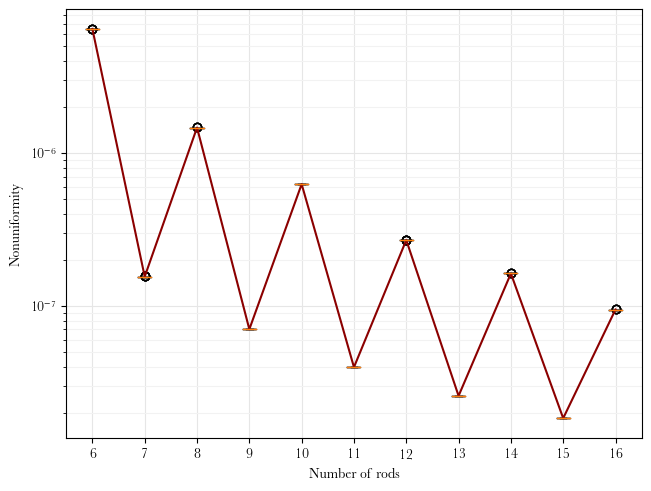

In [6]:
pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,17)]
pp2names = [f'results/halbach/pippin/run1/st2/s2h{n}.csv' for n in range (6,17)]
print(pp1names)
res = []
meds = []
for i in range(len(pp1names)):
    f1 = pd.read_csv(pp1names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 1])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,17))
x = [n for n in range(1, 12)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 12)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
ax.set_yscale('log')
ax.set_ylabel(r'Nonuniformity')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachnonunboxplotst1.png', dpi=1000)

['results/halbach/pippin/run1/st1/h6.csv', 'results/halbach/pippin/run1/st1/h7.csv', 'results/halbach/pippin/run1/st1/h8.csv', 'results/halbach/pippin/run1/st1/h9.csv', 'results/halbach/pippin/run1/st1/h10.csv', 'results/halbach/pippin/run1/st1/h11.csv', 'results/halbach/pippin/run1/st1/h12.csv', 'results/halbach/pippin/run1/st1/h13.csv', 'results/halbach/pippin/run1/st1/h14.csv', 'results/halbach/pippin/run1/st1/h15.csv', 'results/halbach/pippin/run1/st1/h16.csv']


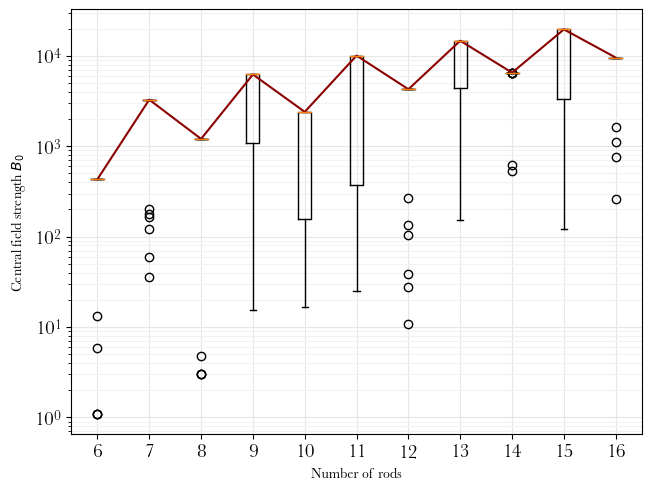

In [7]:
pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,17)]
pp2names = [f'results/halbach/pippin/run1/st2/s2h{n}.csv' for n in range (6,17)]
print(pp1names)
res = []
meds = []
for i in range(len(pp1names)):
    f1 = pd.read_csv(pp1names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 2])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,17))
x = [n for n in range(1, 12)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 12)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
ax.set_yscale('log')
ax.set_ylabel(r'Central field strength $B_0$ (G)')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachbfieldboxplotst1.png', dpi=1000)

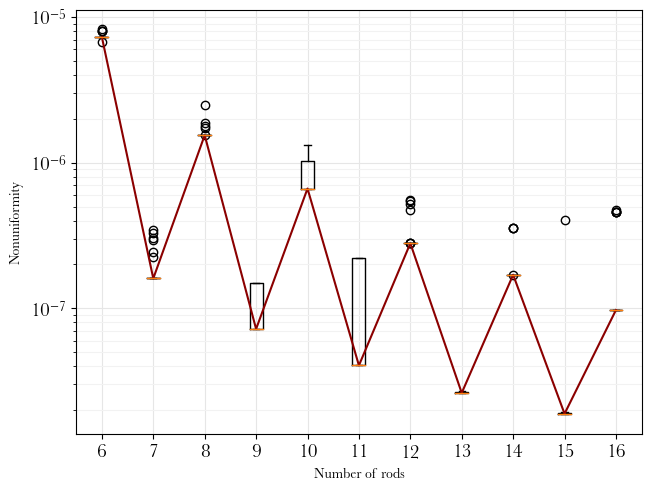

In [9]:
# pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,13)]
pp2names = [f'results/halbach/pippin/run1/st2/s2h{n}.csv' for n in range (6,17)]
res = []
meds = []
for i in range(len(pp2names)):
    f1 = pd.read_csv(pp2names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 1])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,17))
x = [n for n in range(1, 12)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 12)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
ax.set_yscale('log')
ax.set_ylabel(r'Nonuniformity')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachnonunboxplotst2.png', dpi=500)

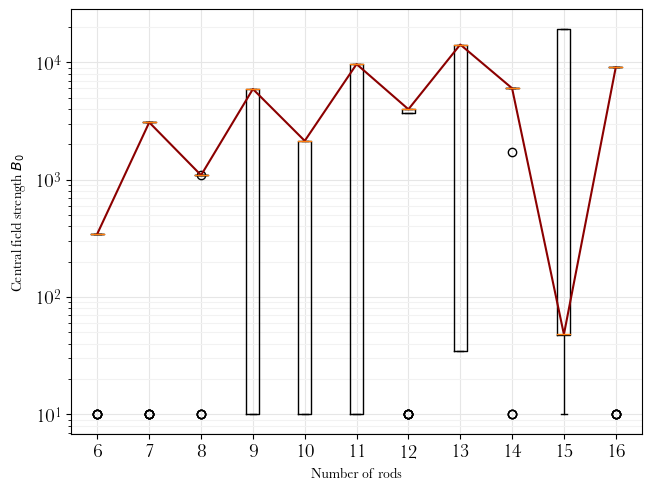

In [10]:
# pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,13)]
pp2names = [f'results/halbach/pippin/run1/st2/s2h{n}.csv' for n in range (6,17)]
res = []
meds = []
for i in range(len(pp2names)):
    f1 = pd.read_csv(pp2names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 2])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,17))
x = [n for n in range(1, 12)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 12)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
ax.set_yscale('log')
ax.set_ylabel(r'Central field strength $B_0$ (G)')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachbfieldboxplotst2.png', dpi=500)

In [13]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

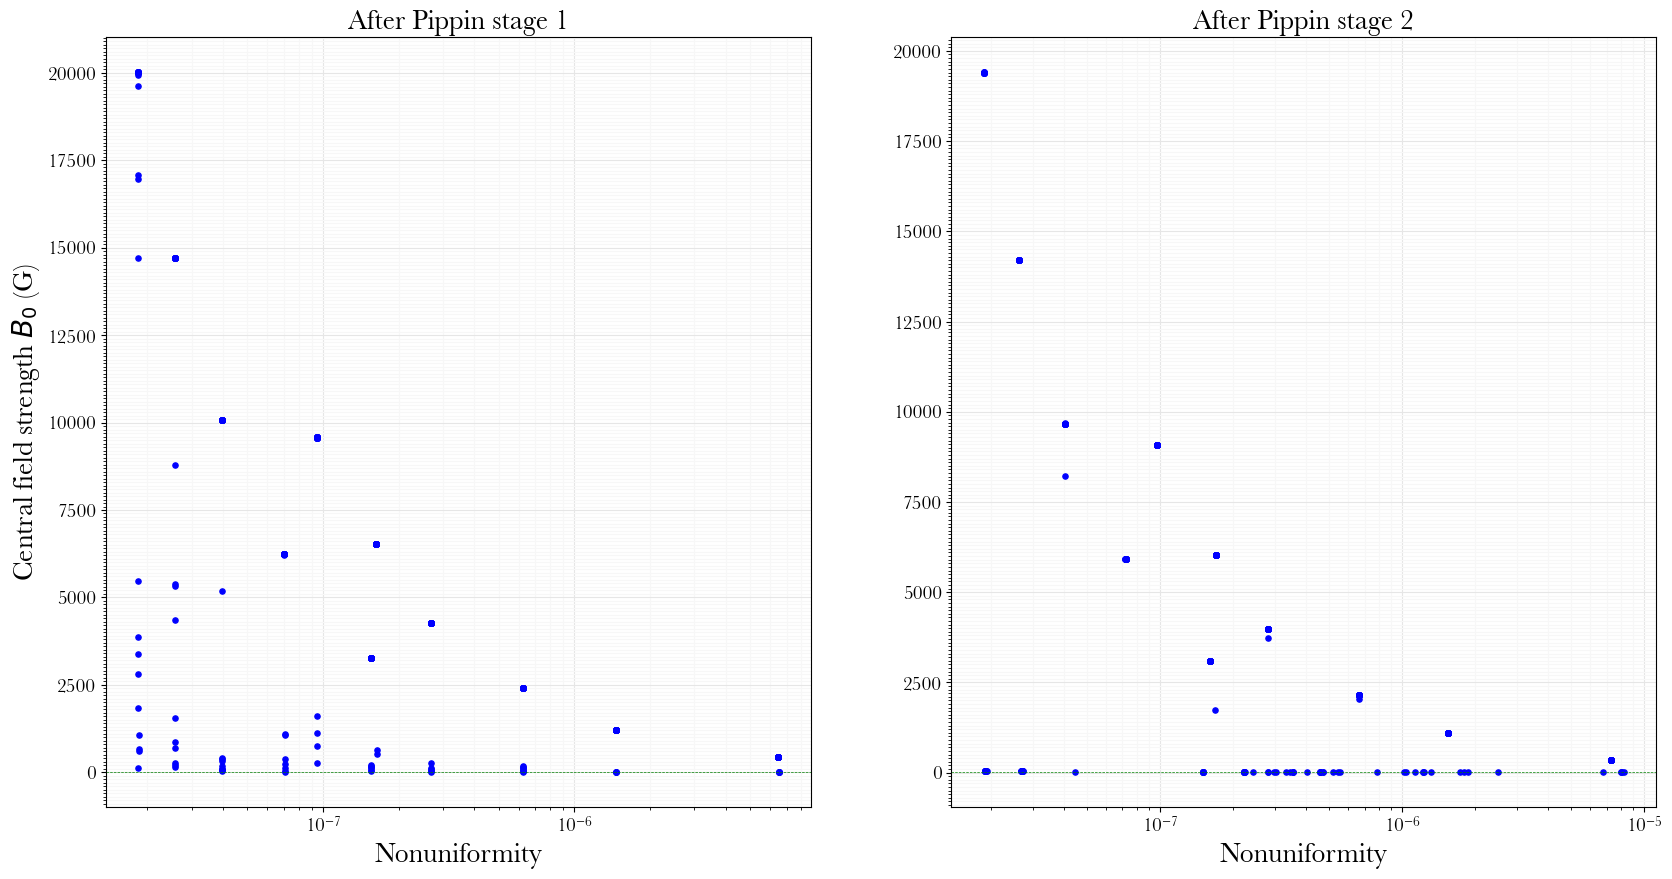

In [17]:
pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,17)]
pp2names = [f'results/halbach/pippin/run1/st2/s2h{n}.csv' for n in range (6,17)]
st1nonun = []
st1g = []
st2nonun = []
st2g = []
for i in range(len(pp2names)):
    f1 = pd.read_csv(pp1names[i])
    f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    f2 = f2.to_numpy()
    tempst1nonun = np.abs(f1[:, 1])
    tempst2nonun = np.abs(f2[:, 1])
    tempst1g = np.abs(f1[:, 2])
    tempst2g = np.abs(f2[:, 2])
    st1nonun.extend(tempst1nonun)
    st2nonun.extend(tempst2nonun)
    st1g.extend(tempst1g)
    st2g.extend(tempst2g)

nonun = [st1nonun, st2nonun]
g = [st1g, st2g]

# print(nonun[0])
# print(nonun[1])

nplots = 2
fig_width = 20
fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/2*fig_width))
axs = axs.flat
headers = ["After Pippin stage 1", "After Pippin stage 2"]

if (nplots == 3):
    res.insert(0, [guess_nonun, guess_cf])
hfont = {'fontname':'Baskerville'}
axs[0].set_ylabel(r"Central field strength $B_0$ (G)", **hfont, fontsize=20)
# fig.supylabel("Central field strength (Gauss)", **hfont)
for i in range(nplots):
    axs[i].set_axisbelow(True)
    axs[i].axhline(10, color="green", linestyle="--", linewidth=0.5)
    # axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
    axs[i].set_xlabel("Nonuniformity", **hfont, fontsize=20)
    axs[i].grid(color='.97', which='minor', axis='both', linestyle='-')
    axs[i].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[i].set_title(headers[i], **hfont, fontsize=20)
    axs[i].set_xscale("log")
    axs[i].scatter(nonun[i], g[i], s=14, color='blue', zorder=1)
    axs[i].yaxis.set_minor_locator(MultipleLocator(100))
# axs[0].yaxis.set_major_locator(MultipleLocator(500))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachst1st2comp.png', dpi=500)

## Samwise

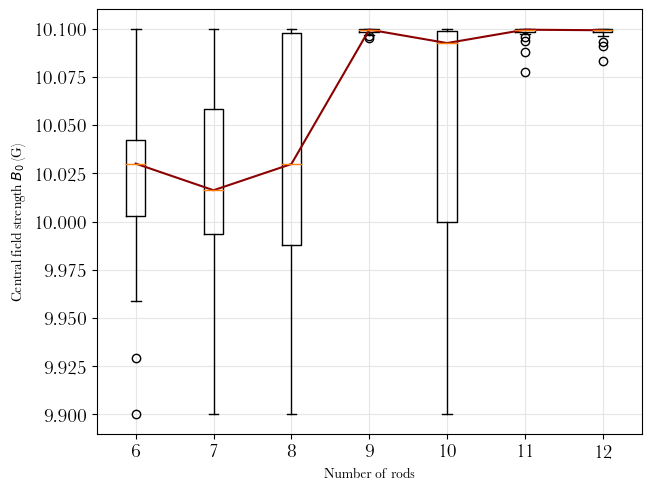

In [20]:
# pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,13)]
pp2names = [f'results/halbach/samwise/{n}_2023_08_15_samwise_halbach_main_1090mT_25.csv' for n in range (6,13)]
res = []
meds = []
for i in range(len(pp2names)):
    f1 = pd.read_csv(pp2names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 2])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,13))
x = [n for n in range(1, 8)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 8)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
# ax.set_yscale('log')
ax.set_ylabel(r'Central field strength $B_0$ (G)')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachbfieldboxplotssamwise.png', dpi=500)

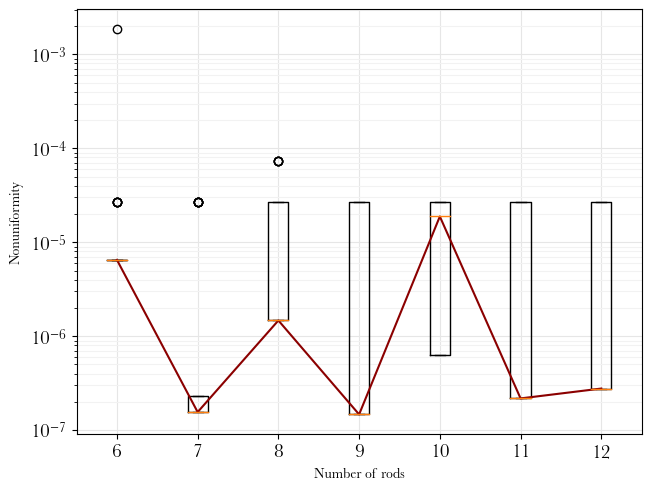

In [8]:
# pp1names = [f'results/halbach/pippin/run1/st1/h{n}.csv' for n in range (6,13)]
pp2names = [f'results/halbach/samwise/{n}_2023_08_15_samwise_halbach_main_1090mT_25.csv' for n in range (6,13)]
res = []
meds = []
for i in range(len(pp2names)):
    f1 = pd.read_csv(pp2names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    pp = np.abs(f1[:, 1])
    # sw = np.abs(f2[:, 1])
    # ppr.append(pp)
    # swr.append(sw)
    res.extend([pp])
    meds.append(np.median(pp))

labels = (f'{n}' for n in range(6,13))
x = [n for n in range(1, 8)]
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
plt.rcParams['font.family'] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
initpos=[i for i in range(1, 8)]
# rects = ax.violinplot(res, positions=initpos, widths=width, showmeans=False, showmedians=True)
rects = ax.boxplot(res, positions=initpos, widths=width)
ax.plot(x, meds, color = 'darkred')
# for attribute, measurement in nring_means.items():
#     offset = width * multiplier
    # rects = ax.violinplot(measurement, positions=[1,1.5, 2.5,3, 4,4.5], widths=width, showmeans=True)
    # ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    # print(offset)
    # print(measurement)
    # rects[0].set_color('purple')
    # multiplier += 1
ax.set_xticks(initpos, labels=labels)
ax.set_yscale('log')
ax.set_ylabel(r'Nonuniformity')
ax.set_xlabel(r'Number of rods')
ax.grid(color='.9', which='major', axis='both', linestyle='-')
ax.grid(color='.95', which='minor', axis='both', linestyle='-')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachnonunboxplotssamwise.png', dpi=500)

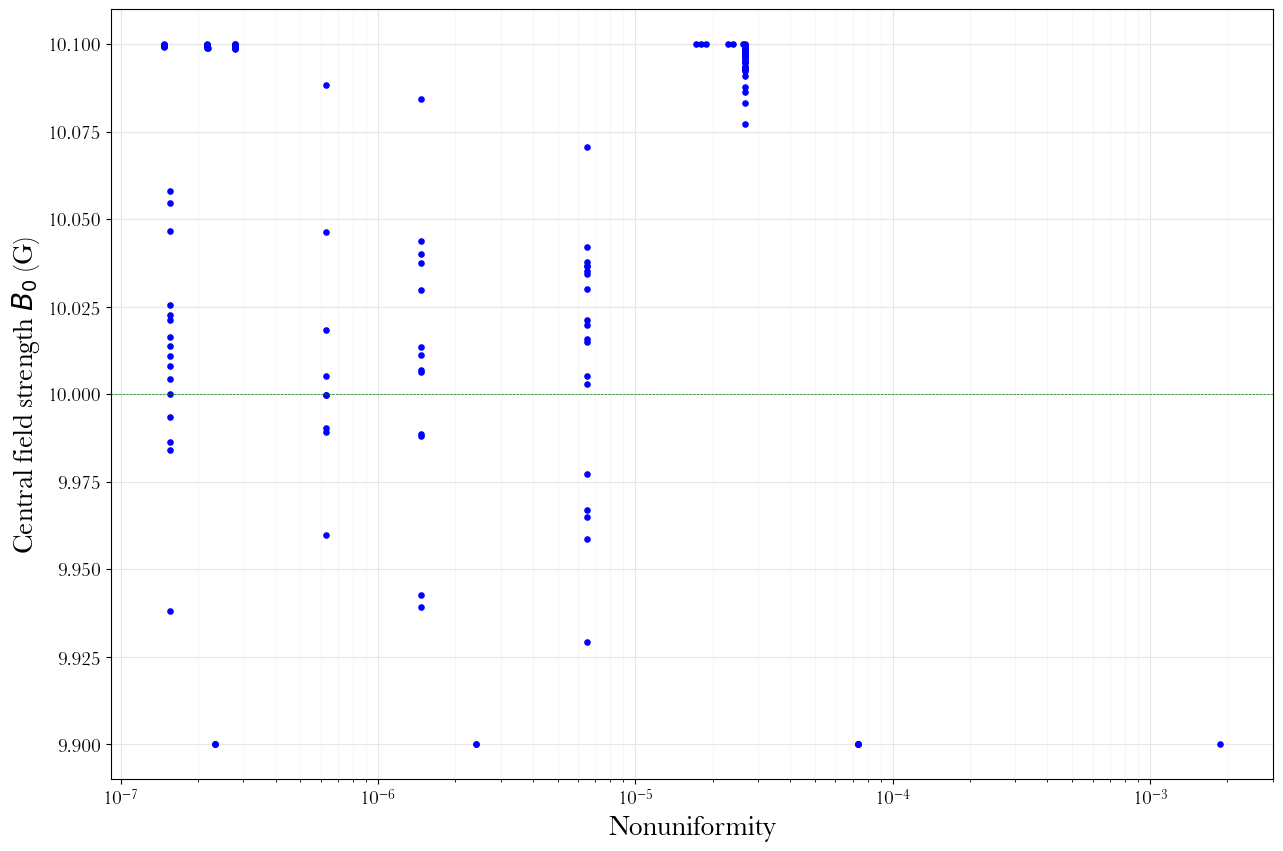

In [19]:
pp1names = [f'results/halbach/samwise/{n}_2023_08_15_samwise_halbach_main_1090mT_25.csv' for n in range (6,13)]
st1nonun = []
st1g = []
# st2nonun = []
# st2g = []
for i in range(len(pp1names)):
    f1 = pd.read_csv(pp1names[i])
    # f2 = pd.read_csv(pp2names[i])
    f1 = f1.to_numpy()
    # f2 = f2.to_numpy()
    tempnonun = np.abs(f1[:, 1])
    # tempst2nonun = np.abs(f2[:, 1])
    tempg = np.abs(f1[:, 2])
    # tempst2g = np.abs(f2[:, 2])
    st1nonun.extend(tempnonun)
    # st2nonun.extend(tempnonun)
    st1g.extend(tempg)
    # st2g.extend(tempst2g)

nonun = [st1nonun]
g = [st1g]

# print(nonun[0])
# print(nonun[1])

nplots = 1
fig_width = 15
fig, axs = plt.subplots(1, nplots, figsize=(fig_width, 1/1.5*fig_width))
# axs = axs.flat
# headers = ["After Pippin stage 1", "After Pippin stage 2"]

if (nplots == 3):
    res.insert(0, [guess_nonun, guess_cf])
hfont = {'fontname':'Baskerville'}
axs.set_ylabel(r"Central field strength $B_0$ (G)", **hfont, fontsize=20)
# fig.supylabel("Central field strength (Gauss)", **hfont)
# for i in range(nplots):
axs.set_axisbelow(True)
axs.axhline(10, color="green", linestyle="--", linewidth=0.5)
# axs[i].axhline(-10, color="green", linestyle="--", linewidth=0.5)
axs.set_xlabel("Nonuniformity", **hfont, fontsize=20)
axs.grid(color='.97', which='minor', axis='both', linestyle='-')
axs.grid(color='.9', which='major', axis='both', linestyle='-')
# axs.set_title(headers[i], **hfont, fontsize=20)
axs.set_xscale("log")
axs.scatter(nonun[0], g[0], s=14, color='blue', zorder=1)
axs.yaxis.set_minor_locator(MultipleLocator(100))
# axs[0].yaxis.set_major_locator(MultipleLocator(500))
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
# plt.show()
plt.savefig('figs/halbachsamwisecomp.png', dpi=500)

[[ 6.88481879e-04 -1.52873687e-19  1.00998989e+00]
 [ 6.86006814e-04 -1.52324112e-19  1.00998989e+00]
 [ 6.83539667e-04 -1.51776295e-19  1.00998989e+00]
 ...
 [-6.83539667e-04  1.51776295e-19  1.00998989e+00]
 [-6.86006814e-04  1.52324112e-19  1.00998989e+00]
 [-6.88481879e-04  1.52873687e-19  1.00998989e+00]]
On x-axis:
Maximum B-field: 10.1 G
Central B-field: 10.1 G
Min nonuniformity: 0.0
Max nonuniformity:3.2146745953079635e-07


On y-axis:
Maximum B-field: 10.1 G
Central B-field: 10.1 G
Min nonuniformity: 0.0
Max nonuniformity:7.147378838457018e-07


On z-axis:
Maximum B-field: 10.107 G
Central B-field: 10.1 G
Min nonuniformity: 0.0
Max nonuniformity:0.0006822918070326701




/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_23952/767950748.py:126: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_23952/767950748.py:132: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_23952/767950748.py:138: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



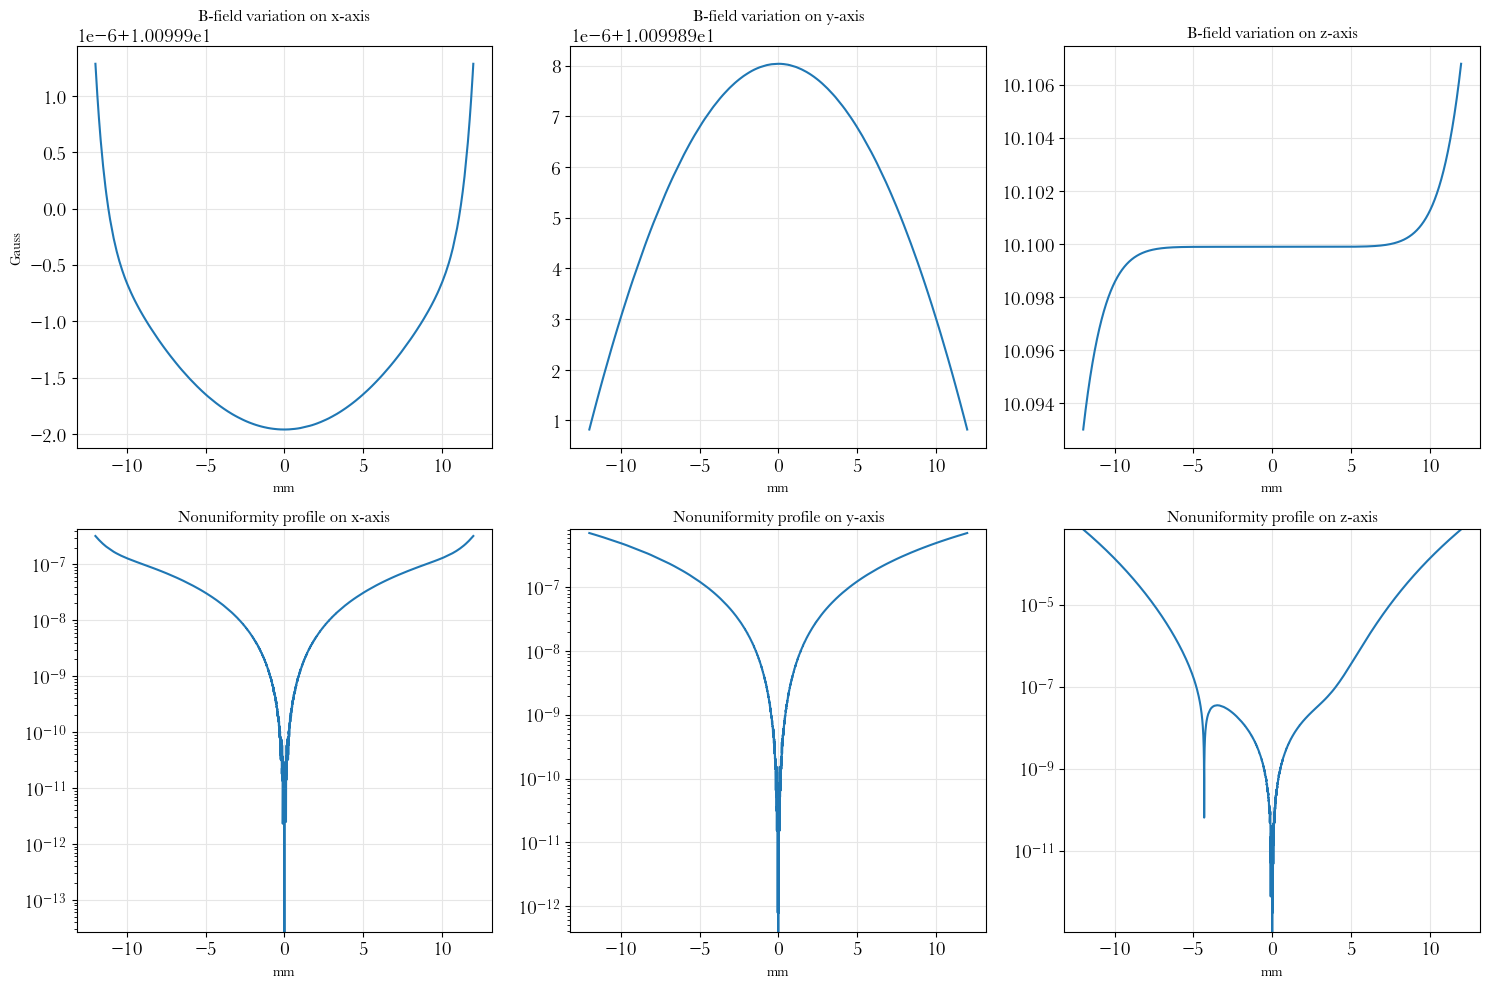

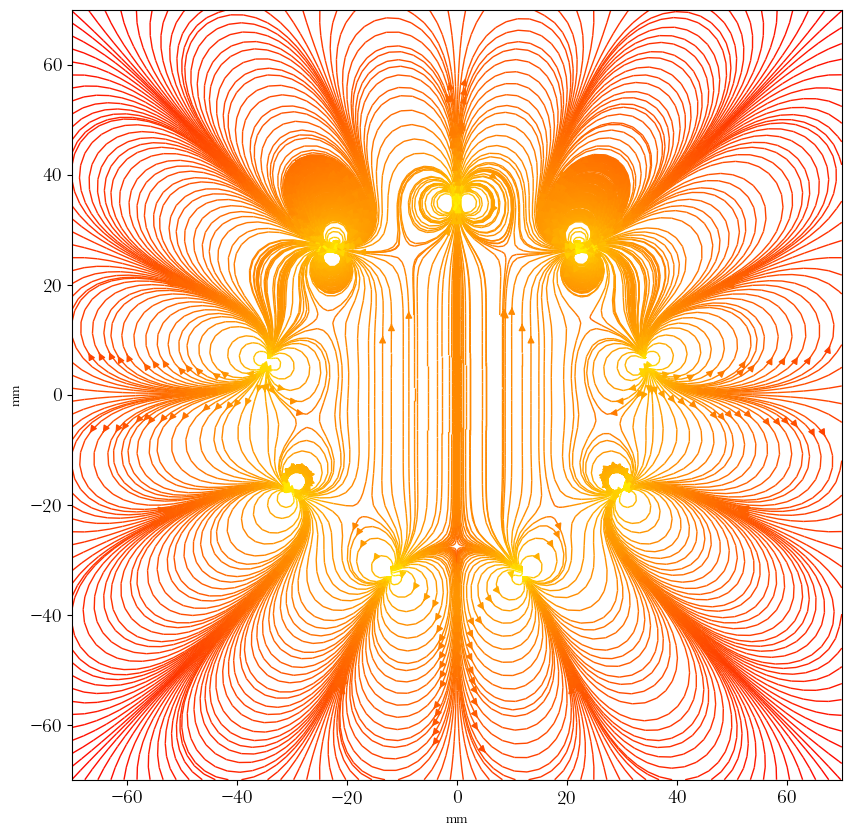

In [36]:
fn = 'results/halbach/samwise/9_2023_08_15_samwise_halbach_main_1090mT_25.csv'
st1 = pd.read_csv(fn)
st1 = np.delete(st1.to_numpy(), [0,1,2], axis=1) #remove first column of indices
x = st1[0]
Br = 1.09e3
c_h = 640
n=9
magnets = halbach_cylinder(Br, x[2], c_h, x[3], n)
grid_res = 101
grid = make_xy_grid([-10, 10], [-10, 10], grid_res)

Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res)
#     results2_nonun.append(obj1_nonuniformity(x))
# results2_g_center.append(center_field)
sens_len = 12
get_field_on_axes(magnets, [[-sens_len, sens_len], [-sens_len, sens_len], [-sens_len, sens_len]], True)

side = 70
x_bounds = [-side, side]
z_bounds = [-side, side]
make_flux_stream(magnets, x_bounds, z_bounds, [])
# print(results2_x)
# print(results2_fun)
# print(results2_nonun)
# print(results2_g_center)

In [39]:
def plot_uniform_region_side_view(magnets, grid_bounds_1, grid_bounds_2, view='xz', contour_res = 1000, discrete_levels = 12, lvls = [[1e-7], [1e-6]], grid_res = 501):
    grid = i0 = i1 = 0
    if view == 'xz':
        grid, i0, i1 = make_xz_grid(grid_bounds_1, grid_bounds_2, grid_res)
    if view == 'xy':
        grid, i0, i1 = make_xy_grid(grid_bounds_1, grid_bounds_2, grid_res)
        
    Gmag, Gnon, Gcenter, av_nonuniformity, max_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res)
    plt.figure(figsize=(7,7))
    plt.gca().set_aspect('equal')
    bgc0 = plt.contourf(i0, i1, Gmag, levels=contour_res, cmap=cm.plasma)
    cp0 = plt.contour(i0, i1, Gmag, levels=discrete_levels, colors='black')
    plt.clabel(cp0, fontsize=10, colors='black')
    plt.colorbar(bgc0)
   
    cp1 = plt.contour(i0, i1, Gnon, levels=lvls[0], colors='white', linestyles='dashed')
    # cp2 = plt.contour(i0, i1, Gnon, levels=lvls[1], colors='white', linestyles='dotted')
    plt.ylabel("mm")
    plt.xlabel("mm")
    plt.savefig("figs/halbachbestcsideview.png", dpi=500)

In [46]:
d = h = 15

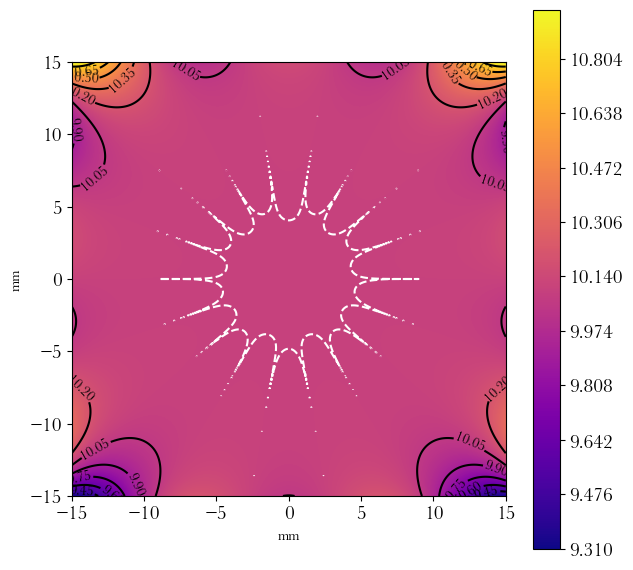

In [47]:
plot_uniform_region_side_view(magnets, [-d, d], [-h, h], lvls=[[1e-7]])